In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np

In [2]:
class UncertaintyTrapEcon:

    def __init__(self,
                a=1.5,          # Risk aversion
                γ_x=0.5,        # Production shock precision
                ρ=0.99,         # Correlation coefficient for θ
                σ_θ=0.5,        # Standard dev of θ shock
                num_firms=100,  # Number of firms
                σ_F=1.5,        # Standard dev of fixed costs
                c=-420,         # External opportunity cost
                μ_init=0,       # Initial value for μ
                γ_init=4,       # Initial value for γ
                θ_init=0):      # Initial value for θ

        # == Record values == #
        self.a, self.γ_x, self.ρ, self.σ_θ = a, γ_x, ρ, σ_θ
        self.num_firms, self.σ_F, self.c, = num_firms, σ_F, c
        self.σ_x = np.sqrt(1/γ_x)

        # == Initialize states == #
        self.γ, self.μ, self.θ = γ_init, μ_init, θ_init

    def ψ(self, F):
        temp1 = -self.a * (self.μ - F)
        temp2 = self.a**2 * (1/self.γ + 1/self.γ_x) / 2
        return (1 / self.a) * (1 - np.exp(temp1 + temp2)) - self.c

    def update_beliefs(self, X, M):
        """
        Update beliefs (μ, γ) based on aggregates X and M.
        """
        # Simplify names
        γ_x, ρ, σ_θ = self.γ_x, self.ρ, self.σ_θ
        # Update μ
        temp1 = ρ * (self.γ * self.μ + M * γ_x * X)
        temp2 = self.γ + M * γ_x
        self.μ = temp1 / temp2
        # Update γ
        self.γ = 1 / (ρ**2 / (self.γ + M * γ_x) + σ_θ**2)

    def update_θ(self, w):
        """
        Update the fundamental state θ given shock w.
        """
        self.θ = self.ρ * self.θ + self.σ_θ * w

    def gen_aggregates(self):
        """
        Generate aggregates based on current beliefs (μ, γ). This
        is a simulation step that depends on the draws for F.
        """
        F_vals = self.σ_F * np.random.randn(self.num_firms)
        M = np.sum(self.ψ(F_vals) > 0)  # Counts number of active firms
        if M > 0:
            x_vals = self.θ + self.σ_x * np.random.randn(M)
            X = x_vals.mean()
        else:
            X = 0
        return X, M

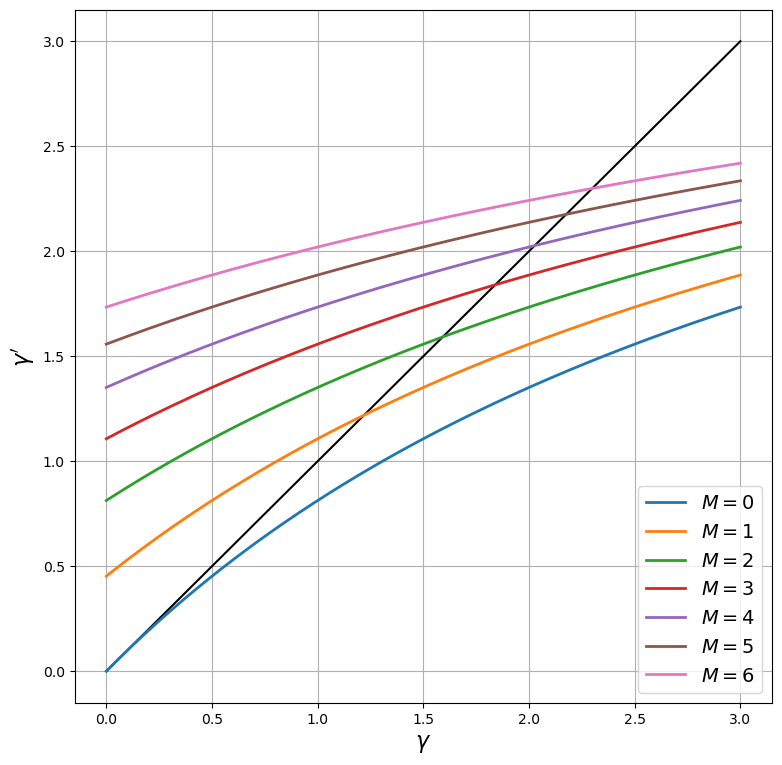

In [3]:
econ = UncertaintyTrapEcon()
ρ, σ_θ, γ_x = econ.ρ, econ.σ_θ, econ.γ_x    # Simplify names
γ = np.linspace(1e-10, 3, 200)              # γ grid
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(γ, γ, 'k-')                         # 45 degree line

for M in range(7):
    γ_next = 1 / (ρ**2 / (γ + M * γ_x) + σ_θ**2)
    label_string = f"$M = {M}$"
    ax.plot(γ, γ_next, lw=2, label=label_string)
ax.legend(loc='lower right', fontsize=14)
ax.set_xlabel(r'$\gamma$', fontsize=16)
ax.set_ylabel(r"$\gamma'$", fontsize=16)
ax.grid()
plt.show()

In [4]:
sim_length=2000

μ_vec = np.empty(sim_length)
θ_vec = np.empty(sim_length)
γ_vec = np.empty(sim_length)
X_vec = np.empty(sim_length)
M_vec = np.empty(sim_length)

μ_vec[0] = econ.μ
γ_vec[0] = econ.γ
θ_vec[0] = 0

w_shocks = np.random.randn(sim_length)

for t in range(sim_length-1):
    X, M = econ.gen_aggregates()
    X_vec[t] = X
    M_vec[t] = M

    econ.update_beliefs(X, M)
    econ.update_θ(w_shocks[t])

    μ_vec[t+1] = econ.μ
    γ_vec[t+1] = econ.γ
    θ_vec[t+1] = econ.θ

# Record final values of aggregates
X, M = econ.gen_aggregates()
X_vec[-1] = X
M_vec[-1] = M

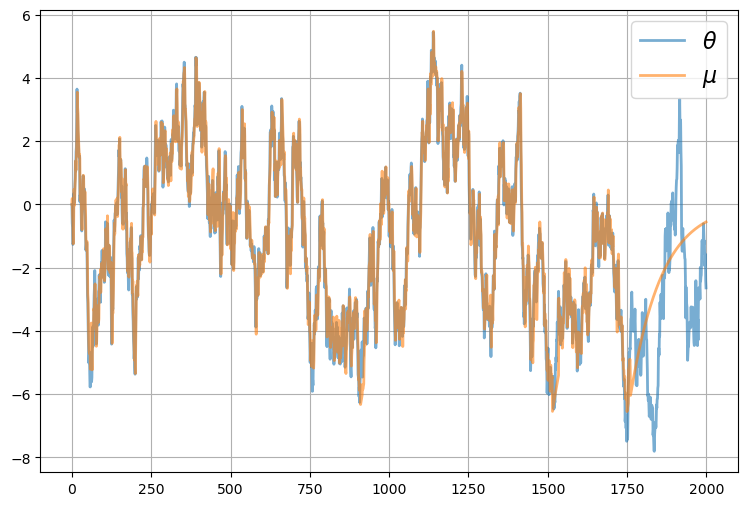

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(sim_length), θ_vec, alpha=0.6, lw=2, label=r"$\theta$")
ax.plot(range(sim_length), μ_vec, alpha=0.6, lw=2, label=r"$\mu$")
ax.legend(fontsize=16)
ax.grid()
plt.show()

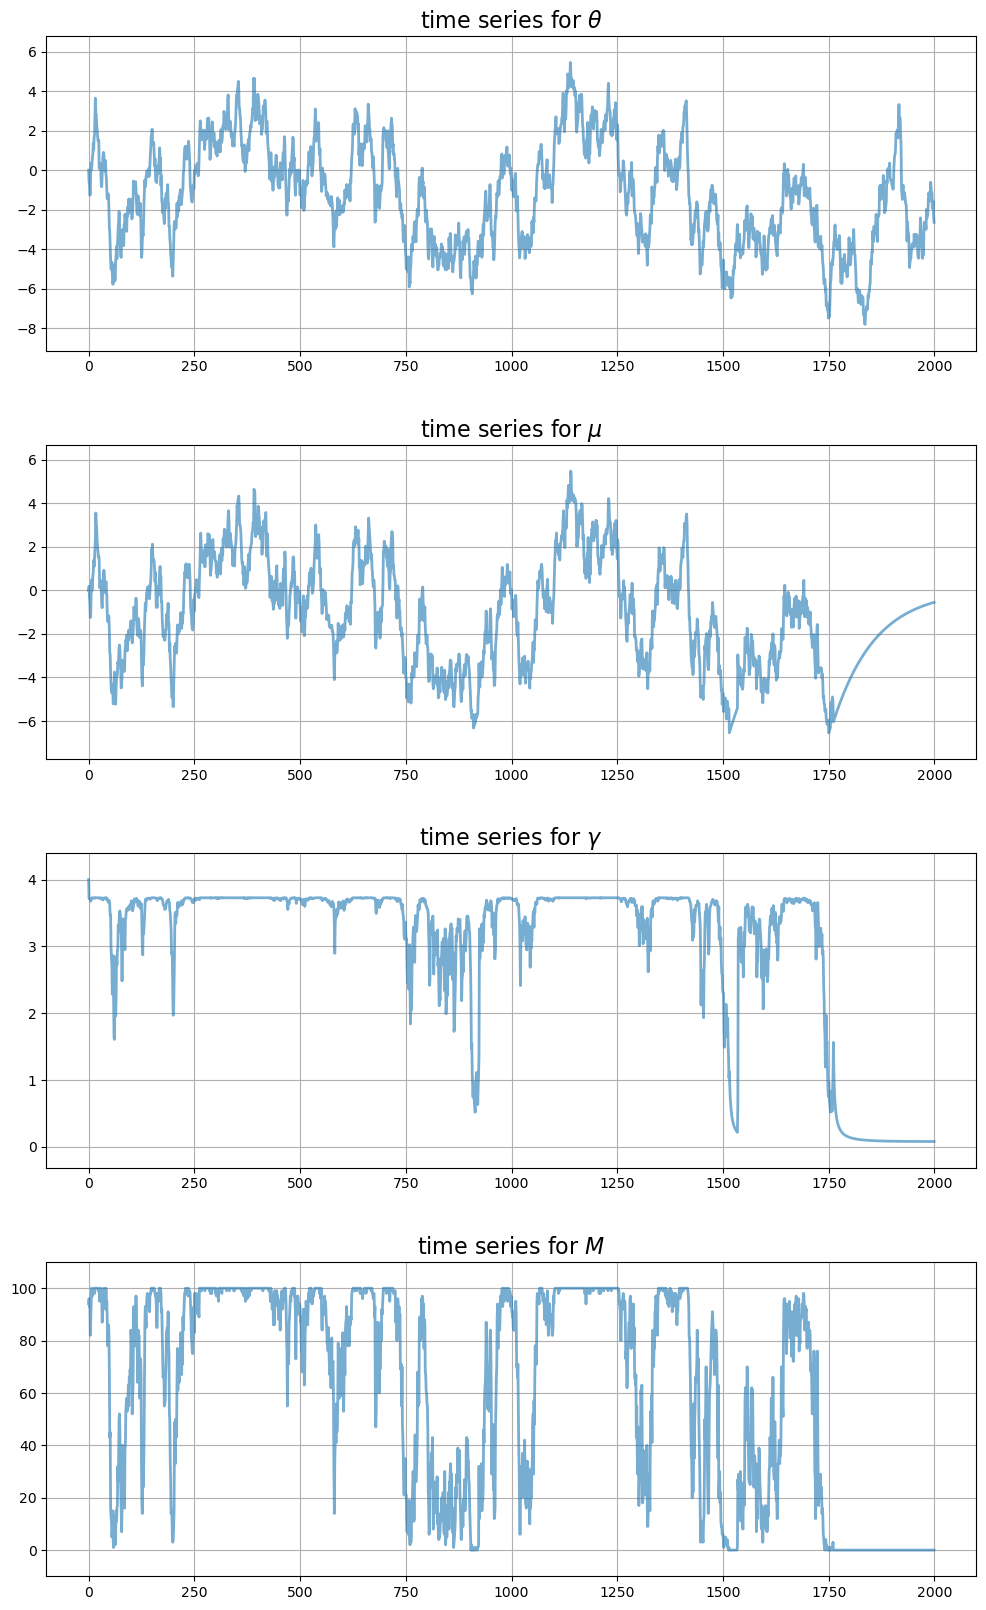

In [6]:
fig, axes = plt.subplots(4, 1, figsize=(12, 20))
# Add some spacing
fig.subplots_adjust(hspace=0.3)

series = (θ_vec, μ_vec, γ_vec, M_vec)
names = r'$\theta$', r'$\mu$', r'$\gamma$', r'$M$'

for ax, vals, name in zip(axes, series, names):
    # Determine suitable y limits
    s_max, s_min = max(vals), min(vals)
    s_range = s_max - s_min
    y_max = s_max + s_range * 0.1
    y_min = s_min - s_range * 0.1
    ax.set_ylim(y_min, y_max)
    # Plot series
    ax.plot(range(sim_length), vals, alpha=0.6, lw=2)
    ax.set_title(f"time series for {name}", fontsize=16)
    ax.grid()

plt.show()